# MSCF 46982 Market Microstructure and Algorithmic Trading
# Fall 2018 Mini 2

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", specify your name and that of your collaborator, and remove the `notimplemented` exception.



---

In [1]:
NAME: "Ze Yang"
COLLABORATOR: ""

## Analyzing trade data from a CSV
Comma Separated Value (CSV) files are a popular means of data storage, but they lack the type precision of other formats (such as JSON or binary).  Kdb+ provides a simple and flexible interface to parsing text from CSV files into a table with proper types for each column. We can then use Kdb+'s `q-sql` syntax to perform data analysis.

### Part A (1 points)

This question has been started for you by downloading sample trade data from [NASDAQ Data-on-Demand](http://www.nasdaqdod.com) into a variable `txt`.  Supply the correct arguments to the `0:` operator to load the "Symbol", "Trades Timestamp", "Trades Quantity" and "Trades Price" columns into a table `t` with data types: symbol, timestamp, integer, real.

In [2]:
\c 10 100
txt:.Q.hg "http://www.nasdaqdod.com/Samples.aspx?SampleId=6"
/ YOUR CODE HERE
t:("S  PIE"; 1#",") 0:txt
show t

Symbol Trades Timestamp              Trades Quantity Trades Price
-----------------------------------------------------------------
NDAQ   2011.06.15D09:30:00.050000000 6820            23.98       
NDAQ   2011.06.15D09:30:00.053000000 6820            23.98       
NDAQ   2011.06.15D09:30:00.377000000 500             23.96       
NDAQ   2011.06.15D09:30:00.393000000 200             23.95       
NDAQ   2011.06.15D09:30:03.493000000 211             23.94       
..


In [3]:
rnd:{x*"j"$y%x}
assert:{if[not x~y;'`$"expecting '",(-3!x),"' but found '",(-3!y),"'"]}
/ confirm the table count is corret
assert[1775] count t
/ confirm the column types are correct
assert["spie"] value[meta t]`t
/ confirm the Symbol column has data for `NDAQ`GOOG
assert[`NDAQ`GOOG] distinct t`Symbol

### Part B (1 points)

The column names of this table have spaces - making them incompatible with `q-sql`.  The operator `.Q.id` removes these illegal characters,

In [4]:
cols .Q.id t

`Symbol`TradesTimestamp`TradesQuantity`TradesPrice


but leaves names that are too verbose (at least for my taste).  This question asks you to use the `xcol` operator to rename the columns such that they can be queried with `q-sql`.

Rename the columns to: sym, time, size, price

In [5]:
/ YOUR CODE HERE
t: `sym`time`size`price xcol t

In [6]:
/ check that the columns are correct
assert[`sym`time`size`price] cols t

### Part C (1 points)

Using the `where` clause with `q-sql`, complete the `filter` function to limit the dataset to only the list of symbols passed as function argument, and only those rows that have non null prices.

In [7]:
filter:{[s;t]
 / YOUR CODE HERE
 t: select from t where sym in s, not null price;
 t}

In [8]:
/ check that the query returnes only the desired symbols
assert[1#`GOOG] distinct filter[`GOOG;t]`sym
assert[1#`NDAQ] distinct filter[`NDAQ;t]`sym
/ check that the returned rows have the expected data
assert[1033] count filter[`GOOG;t]
assert[740] count filter[`NDAQ;t]

### Part D (1 points)

We are looking to generate a volatility profiles from this dataset.  The first step is to generate a table with the open, high, low, close values from each minute of the trading day. Complete the `ohlc` function to return these values for all the symbols in table `t`.  The resulting table should have a two column primary key (sym and minute) and four other columns (o, h, l, c).

HINT: to compute the minute portion of a time value within `q-sql`, you can use `time.minute` syntax.

In [9]:
ohlc:{[t]
 / YOUR CODE HERE
 t: select o:first price, h:max price, l:min price , c:last price by sym,time.minute from t;
 t}

In [10]:
/ check that the function returns the correct columns
assert[`sym`minute`o`h`l`c] cols ohlc filter[`GOOG] t
/ check that the table has the correct number of rows
assert[60] count ohlc filter[`NDAQ] t
/ check column types are correct
assert["sueeee"] value[meta ohlc filter[`GOOG] t]`t
/ check that the data is correct
assert[`o`h`l`c!506.8 507.02 506.58 506.81] rnd[.01] avg ohlc filter[`GOOG] t

### Part E (1 points)

The open, high, low and close columns are useful when computing the intraday volatility.  Though it doesn't account for jumps between periods, the Garman-Klass volatility measure is popular when you have open, high, low and close prices. 

$$\sigma(n)_{gk}=\sqrt{\frac{1}{n}\sum_{i=0}^n \frac{1}{2}\left(\ln(\frac{h_i}{l_i})\right)^2-(2 \ln(2)-1)\left(\ln(\frac{c_i}{o_i})\right)^2}$$

Complete the `gk` function with a simplified implementation of the Garman-Klass measure that produces a variance (volatility squared) without averaging over observations.  For flexibility we will let the caller compute the averag (or moving average), annualize the values, and then take the square root.

$$\sigma_{gk}^2=\frac{1}{2}\left(\ln(\frac{h}{l})\right)^2-(2 \ln(2)-1)\left(\ln(\frac{c}{o})\right)^2$$


In [11]:
/ garman-klass variance estimator
gk:{[o;h;l;c]
 / YOUR CODE HERE
 v:((1f%2f)*r1*r1:log h%l)-(-1f+2f*log 2f)*r2*r2:log c%o;
 v}

In [12]:
/ check that the gk function produces the correct values
assert[0n 1.7222 1.7222 1.1781] rnd[1e-4] gk . (first;max;min;last)@\: 4 cut sums 100#01b

### Part F (1 points)

The open, high, low and close columns are useful when computing the intraday volatility.  Using `q-sql`, complete the `addvol` function to add a new column `volatility` to table `t`. The function should uses the open, high, low and close values along with the `gk` function to compute a variance values for each minute.  It should then use the `mavg` function to compute a moving average over window `w`.  Finally, it should convert the variance numbers to **volatility**. Make sure to annualize the numbers with 6.5 hours in a trading day and 252 trading days per year.

In [13]:
addvol:{[w;t]
 / YOUR CODE HERE
 t:update volatility:sqrt 252*6.5*60*w mavg gk[o;h;l;c] by sym from t;
 t}

In [14]:
/ check that the table now has the volatility column
assert[1b] `volatility in cols addvol[5] ohlc filter[`GOOG] t
/ check that the volatility values are correct
assert[`GOOG`NDAQ!0.1748 0.1316] rnd[1e-4] exec avg volatility by sym from addvol[5] ohlc filter[`NDAQ`GOOG] t

### Part G (1 points)

In combination with the `filter`, `ohlc` and the `addvol` functions, use the `pivot` function to generate a time series of GOOG and NDAQ's volatility (using a moving window of 5).  The result should be saved into a table `s` and have three columns: minute (the primary key), GOOG and NDAQ.

In [15]:
/ create pivot (t)able with data from the last column
/ pivot columns from the last key column
/ and pivot keys as all but the last key column
pivot:{[t]
 u:`$string asc distinct last f:flip key t;
 pf:{x#(`$string y)!z};
 p:?[t;();g!g:-1_ k;(pf;`u;last k:key f;last key flip value t)];
 p} 

In [16]:
/ YOUR CODE HERE
show s:pivot 2!select minute,sym,volatility from addvol[5] ohlc filter[`NDAQ`GOOG] t

minute| GOOG      NDAQ     
------| -------------------
09:30 | 0.316194  0.599801 
09:31 | 0.2770435 0.4241233
09:32 | 0.323622  0.3500383
09:33 | 0.294405  0.3039447
09:34 | 0.3383625 0.3097547
..


In [17]:
/ check that the table has the correct columns
assert[`minute`GOOG`NDAQ] cols s
/ check that the table has the right number of rows
assert[60] count s
/ check that the avg volatility 
assert[`GOOG`NDAQ!0.1748 0.1316] rnd[1e-4] avg s

### Part H (1 points)

Integrating Kdb+ with Jupyter Notebooks allows you to use the power of python's plotting tools.

This problem requests that you to copy the table `s` from the q memory space into the python memory space and call it `s`.

In [18]:
/ YOUR CODE HERE
tab2df:{r:.p.import[`pandas;`:DataFrame.from_dict;flip 0!x][@;cols x];$[count k:keys x;r[`:set_index]k;r]}
.p.set[`s] tab2df s

In [19]:
/ check that the python variable df now contains exactly the same data as the q variable s
df2tab:{
 n:$[.p.isinstance[x`:index;.p.import[`pandas]`:RangeIndex]`;0;x[`:index.nlevels]`];
 t:n!flip $[n;x[`:reset_index][];x][`:to_dict;`list]`;
 t}
assert[s] update "u"$minute from df2tab .p.get[`s]

### Part I (1 points)

This problem asks that you load the proper python libraries into the python namespace such that `numpy` can be referred to as `np`, `pandas` can be referred to as `pd` and `matplotlib.pyplot` can be referred to as `plt`.

In [20]:
/%python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"p)import numpy as np"
"p)import pandas as pd"
"p)import matplotlib.pyplot as plt"


"p)# check that we can now plot s"
"p)s.index = pd.to_timedelta(s.index,unit='m')"
"p)s.plot(figsize=(15,5),title='google vs nasdaq intraday volatility')"
"p)plt.show()"


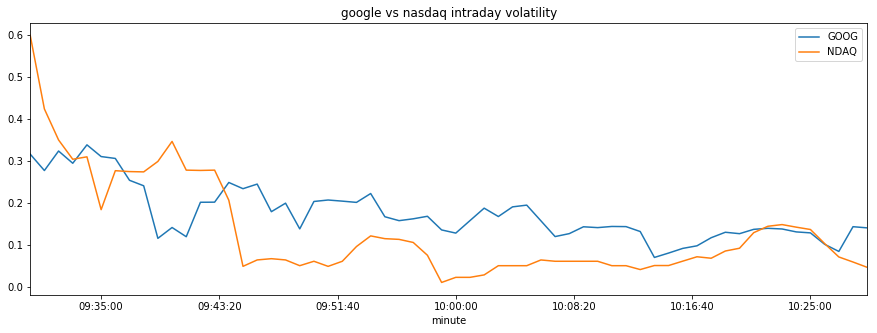

In [21]:
/%python
# check that we can now plot s
s.index = pd.to_timedelta(s.index,unit='m')
s.plot(figsize=(15,5),title='google vs nasdaq intraday volatility')
plt.show()

### Part J (1 points)

Pulling everything together, this question asks you summarize the notional traded by each stock in the data set in minutely buckets.  The term notional represents the traded value in units of dollars.  The `size` column is not comparable between `GOOG` and `NDAQ`, but the notional (size x price) is.  Sum each stock's total notional traded within each minute bucket, pivot the table and assign the result to the variable `v` in the python namespace.

In [22]:
/ YOUR CODE HERE
doltrd1m:{[t] select notional: sum price*size by sym,time.minute from t}
show v:pivot 2!select minute,sym,notional from doltrd1m filter[`NDAQ`GOOG] t
.p.set[`v] tab2df v

minute| GOOG       NDAQ  
------| -----------------
09:30 | 1.7394e+07 368231
09:31 | 1411268    2390  
09:32 | 2845642    7172  
09:33 | 802662.4   11971 
09:34 | 1632652    11996 
..


In [23]:
/ confirm v has the desired columns
assert[`minute`GOOG`NDAQ] cols df2tab .p.get[`v]
/ confirm v has the desired row count
assert[60] count df2tab .p.get[`v]
/ confirm v has the correct data
assert[`GOOG`NDAQ!1255041 43125] rnd[1] avg df2tab .p.get[`v]

"p)# check that we can now plot v"
"p)import pandas as pd"
"p)v.index = pd.to_timedelta(v.index,unit='m')"
"p)v.plot(figsize=(15,5),title='google vs nasdaq intraday volume')"
"p)plt.show()"


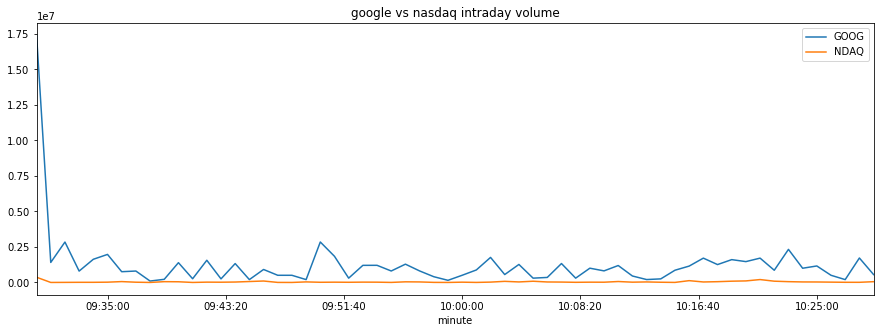

In [24]:
/%python
# check that we can now plot v
import pandas as pd
v.index = pd.to_timedelta(v.index,unit='m')
v.plot(figsize=(15,5),title='google vs nasdaq intraday volume')
plt.show()